In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ahemateja19bec1025_traffic_sign_dataset_classification_path = kagglehub.dataset_download('ahemateja19bec1025/traffic-sign-dataset-classification')

print('Data source import complete.')


100%|██████████| 190M/190M [00:02<00:00, 70.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os, random
import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore', message="DataFrame is highly fragmented")

import pickle

# Data Loading

In [ ]:
base_dir = ahemateja19bec1025_traffic_sign_dataset_classification_path + "/traffic_Data/DATA/"

# class_folder_names = os.listdir(base_dir)
class_folder_names = ['0', '4', '6', '11', '12', '14', '17']
class_folder_names

In [ ]:
image_paths = []

for cls in class_folder_names:

    for file_name in os.listdir(base_dir+cls):
        if file_name.split('.')[-1] == 'png':
            image_paths.append(os.path.join(base_dir,cls,file_name))

print("A total images = ", len(image_paths))
print("-------------------------------")

image_paths[0:10]

In [ ]:
classes = []

for image_path in image_paths:
    classes.append(image_path.split('/')[-2])

classes[0:5]

                     Data loading is done.

# Data Preprocessing

In [ ]:
inputs = []

for i in  tqdm(image_paths):  # image_paths[0:2]
    image = load_img(i, target_size=(100,100))
    img_array = img_to_array(image)
    inputs.append(img_array)

X = np.array(inputs)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(classes)
y = np.array(y)

print(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("Train data = ", X_train.shape,  y_train.shape)
print("Test data = ", X_test.shape,  y_test.shape)

In [ ]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

print("Flattened Train data = ", X_train_flattened.shape,  y_train.shape)
print("Flattened Test data = ", X_test_flattened.shape,  y_test.shape)

                            Data Preprocessing is done.

# Data Visualization

In [ ]:
# Create a dictionary to store indices of samples for each class

unique_classes = np.unique(y_train)
class_indices = {class_id: np.where(y_train == class_id)[0] for class_id in unique_classes}
class_indices

In [ ]:
# ploting total samples for each class

images_count = [len(class_indices[key]) for key in class_indices.keys()]

fig = px.bar(x=class_folder_names, y=images_count, color= class_folder_names)

fig.update_layout(xaxis_title='Traffic signs', yaxis_title='Count', title="Total samples for each class", )
fig.update_traces(texttemplate='%{y}', textposition='inside')

fig.show()

In [ ]:
# Displaying sample images for each class randomly.

plt.figure(figsize=(12, 5))

for i, (class_id, indices) in enumerate(class_indices.items()):
    random_index = np.random.choice(indices)
    random_image = X_train[random_index].astype(np.uint8)

    plt.subplot(1, len(unique_classes), i + 1)
    plt.imshow(random_image)
    plt.title(class_folder_names[class_id])
    plt.axis('off')

plt.show()

In [ ]:
#Displaying 7 sample images for each class randomly.

selected_classes = [0, 1, 2,3,4,5,6]
total_images_per_class = 7

plt.figure(figsize=(20, 8))

for c, selected_class in enumerate(selected_classes):

    # Get indices of samples for the selected class
    indices_for_selected_class = np.where(y_train == selected_class)[0]
    random_indices = np.random.choice(indices_for_selected_class, total_images_per_class, replace=False)

    # Display images for the current selected class
    for i, idx in enumerate(random_indices):
        plt.subplot(7, 7, c * total_images_per_class + i + 1)
        plt.imshow(X_train[idx].astype(np.uint8))
        plt.title(class_folder_names[selected_class])
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Reshape the image data to a 2D array
num_samples, height, width, channels = X_train.shape

X_train_reshaped = X_train.reshape(num_samples, height * width * channels)
X_train_flattened.shape

In [ ]:
# Apply PCA to reduce dimensions to 2 for visualization

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_flattened)
X_train_pca.shape

In [ ]:
# Visualize the PCA-transformed data

hover_text = [f"Index: {index}" for index in range(len(X_train_pca))]

fig = px.scatter(x=X_train_pca[:, 0], y=X_train_pca[:, 1], color=y_train, hover_name=hover_text, symbol=y_train, title='PCA Visualization of Image Classes')
fig.update_traces(marker=dict(size=15))
fig.update_layout(xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')
fig.update_layout(coloraxis_showscale=False)

fig.show()

In [ ]:
# Finding outliers by talking high distance sum values

pca_sums = np.sum(X_train_pca, axis=1)

outlier_indexes = []
for idx, row in enumerate(pca_sums):
    if row>15000:
        print(row, idx)
        outlier_indexes.append(idx)

In [ ]:
# Displaying outlier images

plt.figure(figsize=(30, 6))

for i, outlier in enumerate(outlier_indexes):
    outlier_image = X_train[outlier].astype(np.uint8)

    plt.subplot(1, len(outlier_indexes), i+1)
    plt.imshow(outlier_image)
    title = class_folder_names[y_train[outlier]]
    plt.title(title)
    plt.axis('off')

plt.show()

In [ ]:
pca_df = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y_train
pca_df['Index'] = pca_df.index
pca_df.head()

In [ ]:
# Create side-by-side box plots for PC1 and PC2 using Plotly

fig = px.box(pca_df, x='Class', y=['PC1', 'PC2'], points="all", facet_col="variable",
             title='Box Plots of PCA - Principal Components 1 and 2 by Class', hover_data={'Index': True})
fig.update_layout(width=1200, height=500)
fig.show()

                           Data Visualization is done.

# ML Model Training

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),

}

In [ ]:
accuracies = {}

for name, model in models.items():

    model.fit(X_train_flattened, y_train)
    predictions = model.predict(X_test_flattened)

    accuracy = accuracy_score(y_test, predictions)
    accuracies[name] = accuracy

    print(f"{name} accuracy: {accuracy}")


In [ ]:
# Find the best model based on accuracy
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]

print("Best model = ", best_model )

In [ ]:
# Train the best model
best_model.fit(X_train_flattened, y_train)
best_predictions = best_model.predict(X_test_flattened)

best_predictions

In [ ]:
# Get weights

if best_model_name == 'Random Forest' or best_model_name == 'Decision Tree':
    coefficients = best_model.feature_importances_
    print(coefficients.shape)

elif best_model_name == 'Logistic Regression':
    coefficients = best_model.coef_.ravel()
    print(coefficients.shape)
else:
    coefficients = None

In [ ]:
# ploting weights distribution

if coefficients is not None:
    fig = px.histogram(x=coefficients, nbins=50, labels={'x': 'Coefficient Value'}, title='Distribution of Coefficients (Weights)')
    fig.update_layout(bargap=0.1)
    fig.update_traces(opacity=0.7)
    fig.show()

               ML Model training is done.

# Metrics & Reports

In [ ]:
report = classification_report(y_test, best_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        27
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        19

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158



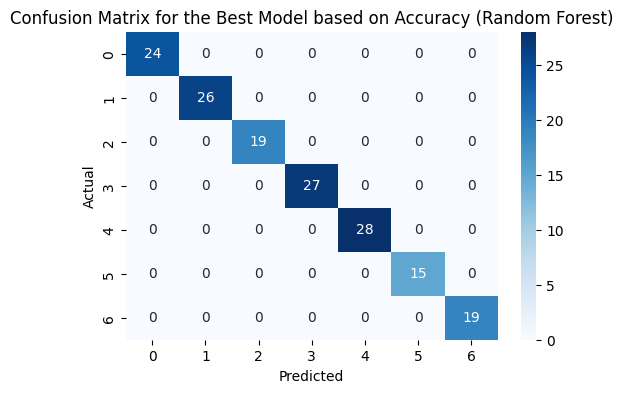

In [ ]:
# Calculate and display the confusion matrix for the best model
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title(f'Confusion Matrix for the Best Model based on Accuracy ({best_model_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

                   Metrics & Reports is done.

# Model Deployment

In [ ]:
# Save the trained model
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
# Load the saved model
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

loaded_model

RandomForestClassifier()

In [ ]:
# Predicting on loaded model with X_test_flattened

predictions = loaded_model.predict(X_test_flattened)
predictions

array([3, 3, 2, 0, 1, 4, 4, 2, 6, 1, 4, 2, 1, 4, 6, 4, 6, 0, 1, 1, 1, 3,
       0, 0, 0, 0, 2, 3, 2, 3, 1, 0, 3, 0, 4, 2, 0, 4, 6, 5, 4, 6, 3, 5,
       6, 0, 3, 4, 0, 5, 4, 4, 0, 5, 1, 6, 2, 3, 2, 1, 0, 4, 3, 4, 0, 4,
       1, 1, 0, 0, 1, 1, 6, 2, 6, 4, 1, 4, 3, 1, 3, 4, 3, 3, 5, 2, 3, 4,
       6, 1, 4, 3, 1, 5, 4, 5, 3, 6, 2, 2, 3, 2, 1, 4, 2, 4, 0, 0, 3, 1,
       6, 5, 3, 4, 5, 6, 6, 0, 2, 0, 3, 1, 6, 4, 6, 5, 3, 0, 1, 0, 5, 2,
       2, 3, 3, 4, 3, 3, 4, 1, 6, 2, 1, 1, 5, 3, 6, 6, 5, 4, 5, 5, 1, 0,
       1, 4, 2, 0])

In [ ]:
# Predicting a single image on loaded model

random_image_path = random.choice(image_paths)
actual_class = random_image_path.split('/')[-2]

print("Random Image Path = ", random_image_path)
print("Its original class = ", actual_class)

Random Image Path =  /root/.cache/kagglehub/datasets/ahemateja19bec1025/traffic-sign-dataset-classification/versions/2/traffic_Data/DATA/14/014_1_0022.png
Its original class =  14


In [ ]:
# Image preprocessing for prediction

random_image = load_img(random_image_path, target_size=(100,100))
random_img_array = img_to_array(random_image)

# Reshape the array to have the desired number of features
flattend_img_array = random_img_array.reshape(1, -1)

print(flattend_img_array.shape)


(1, 30000)


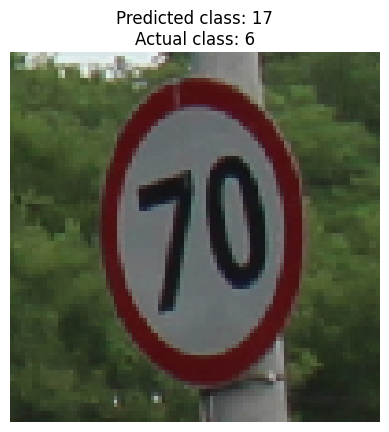

In [ ]:
# Predicting a single image on loaded model

random_image_path = random.choice(image_paths)
actual_class = random_image_path.split('/')[-2]

# Image preprocessing for prediction

random_image = load_img(random_image_path, target_size=(100,100))
random_img_array = img_to_array(random_image)

# Reshape the array to have the desired number of features
flattend_img_array = random_img_array.reshape(1, -1)

predictions = loaded_model.predict(flattend_img_array)

predicted_class = class_folder_names[predictions[0]]
actual_class = random_image_path.split('/')[-2]

plt.imshow(random_image)
plt.title(f"Predicted class: {predicted_class}\nActual class: {actual_class}")
plt.axis('off')
plt.show()
